In [1]:
import networkx as nx
import matplotlib.pyplot as plt

def generate_graph_plot(data_string):
    lines = data_string.strip().split('\n')

    header = lines[0].split()
    n_edges = int(header[1])

    edge_lines = lines[1 : 1 + n_edges]
    node_lines = lines[1 + n_edges : -1]
    
    path_info = lines[-1].split()
    start_node = path_info[0]
    end_node = path_info[1]

    G = nx.DiGraph()

    for line in edge_lines:
        parts = line.split()
        u, v, w = parts[0], parts[1], int(parts[2])
        G.add_edge(u, v, weight=w)

    for line in node_lines:
        parts = line.split()
        node = parts[0]
        h_value = int(parts[1])
        if node not in G:
            G.add_node(node)
        G.nodes[node]['h'] = h_value

    layers = {n: 0 for n in G.nodes()}
    
    try:
        sorted_nodes = list(nx.topological_sort(G))
        for node in sorted_nodes:
            current_depth = layers[node]
            for child in G.successors(node):
                if layers[child] < current_depth + 1:
                    layers[child] = current_depth + 1
    except nx.NetworkXUnfeasible:
        pass

    for node, depth in layers.items():
        G.nodes[node]['subset'] = depth

    node_colors = []
    for n in G.nodes():
        if n == start_node:
            node_colors.append("orange")
        elif n == end_node:
            node_colors.append("red")
        else:
            node_colors.append('lightblue')

    node_labels = {}
    for n in G.nodes():
        h_val = G.nodes[n].get('h', '?')
        node_labels[n] = f"{n}\n(h={h_val})"
        
    edge_labels = nx.get_edge_attributes(G, "wei+ght")

    fig, ax = plt.subplots(figsize=(14, 8))
    
    pos = nx.multipartite_layout(G, subset_key='subset')
    
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1500, ax=ax)    
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrowsize=20, ax=ax)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, ax=ax)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, ax=ax)
    
    ax.set_title(f"Graph Visualization: {start_node} to {end_node}")
    ax.axis('off')
    
    return fig

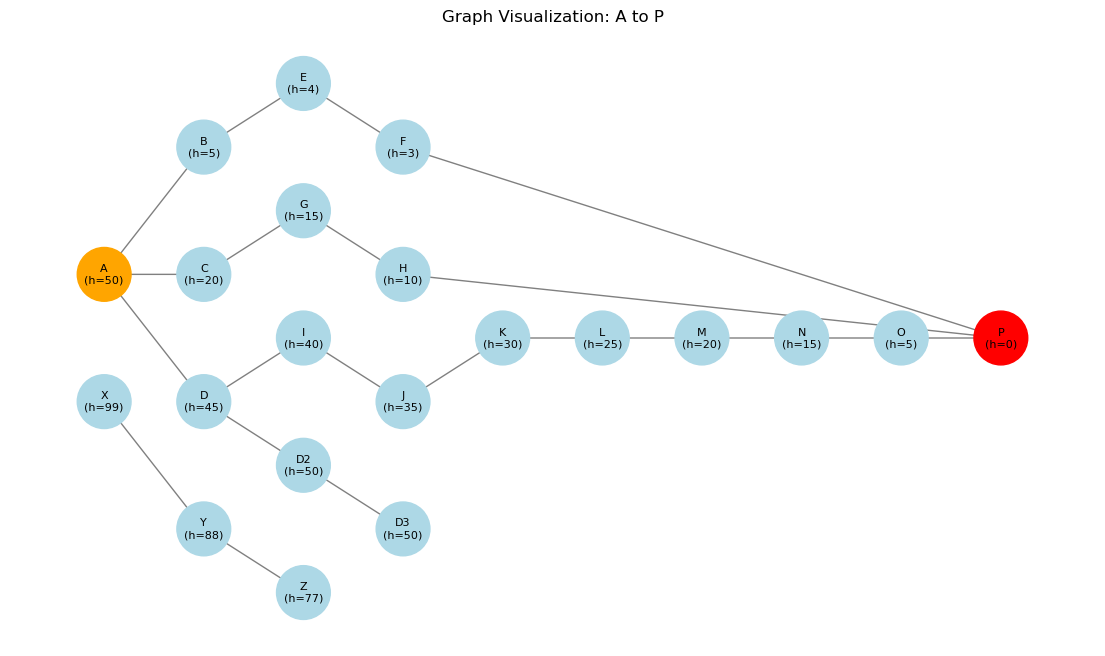

In [2]:
raw_data = """19 21
A B 1
A C 5
A D 2
B E 1
E F 1
F P 50
C G 2
G H 2
H P 2
D I 1
I J 1
J K 1
K L 1
L M 1
M N 1
N O 1
O P 100
D D2 1
D2 D3 1
X Y 5
Y Z 5
A 50
B 5
C 20
D 45
E 4
F 3
G 15
H 10
I 40
J 35
K 30
L 25
M 20
N 15
O 5
D2 50
D3 50
P 0
X 99
Y 88
Z 77
A P"""

fig = generate_graph_plot(raw_data)
plt.show()

In [3]:
def highlight_path_in_data(original_data, path):
    mapping = {node: f"*{node}*" for node in path}
    new_lines = []
    
    for line in original_data.strip().split('\n'):
        parts = line.split()
        new_parts = []
        for word in parts:
            if word in mapping:
                new_parts.append(mapping[word])
            else:
                new_parts.append(word)
        new_lines.append(" ".join(new_parts))

    return "\n".join(new_lines)    

## Beam Search

In [4]:
def solve_beam_search(data, beam_width = 2):
    lines = data.strip().split('\n')
    n_edges = int(lines[0].split()[1])
    edge_lines = lines[1:1 + n_edges]
    node_lines = lines[1 + n_edges:-1]
    start, end = lines[-1].split()
    
    heuristics = {}
    for line in node_lines:
        line_key, line_value = line.split()
        heuristics[line_key] = int(line_value)
    
    graph = {}
    for line in edge_lines:
        part_start, part_end, part_cost = line.split()
        if part_start not in graph:
            graph[part_start] = []
        graph[part_start].append((part_end, int(part_cost)))
    
    start_f = 0 + heuristics.get(start, 0)
    current_beam = [(start_f, start)]
    cost_so_far = {start:0}
    came_from = {start:None}    
    step = 0
    
    while current_beam:
        step += 1
        print(f"Step {step} | width: {beam_width} | current beam: {current_beam}")
    
        next_candidates = []
        for parent_f, parent_node in current_beam:
            if parent_node == end:
                print("Goal found! Hooray!")
                path = []
                curr = end
                while curr:
                    path.append(curr)
                    curr = came_from[curr]
                path.reverse()
                return path, cost_so_far
                
    
            for neighbor, weight in graph.get(parent_node, []):
                new_g = cost_so_far[parent_node] + weight
    
                if new_g <cost_so_far.get(neighbor, float('inf')):
                    cost_so_far[neighbor] = new_g
                    came_from[neighbor] = parent_node
    
                    new_f = new_g + heuristics.get(neighbor, 0)
                    next_candidates.append((new_f, neighbor))
    
        if not next_candidates:
            break
        next_candidates.sort(key=lambda x:x[0])
        current_beam = next_candidates[:beam_width]
        print(current_beam)
            
    return None, cost_so_far

In [8]:
path_result = solve_beam_search(raw_data)

Step 1 | width: 2 | current beam: [(50, 'A')]
[(6, 'B'), (25, 'C')]
Step 2 | width: 2 | current beam: [(6, 'B'), (25, 'C')]
[(6, 'E'), (22, 'G')]
Step 3 | width: 2 | current beam: [(6, 'E'), (22, 'G')]
[(6, 'F'), (19, 'H')]
Step 4 | width: 2 | current beam: [(6, 'F'), (19, 'H')]
[(11, 'P'), (53, 'P')]
Step 5 | width: 2 | current beam: [(11, 'P'), (53, 'P')]
Goal found! Hooray!


In [9]:
path_result

(['A', 'C', 'G', 'H', 'P'],
 {'A': 0, 'B': 1, 'C': 5, 'D': 2, 'E': 2, 'G': 7, 'F': 3, 'H': 9, 'P': 11})

In [13]:
foo = highlight_path_in_data(raw_data, path_result[0])

In [14]:
risky_data = """6 6
Start A 1
Start B 1
A Goal 1
B C 1
C D 1
D Goal 100
Start 0
A 100
B 1
C 1
D 1
Goal 0
Start Goal"""

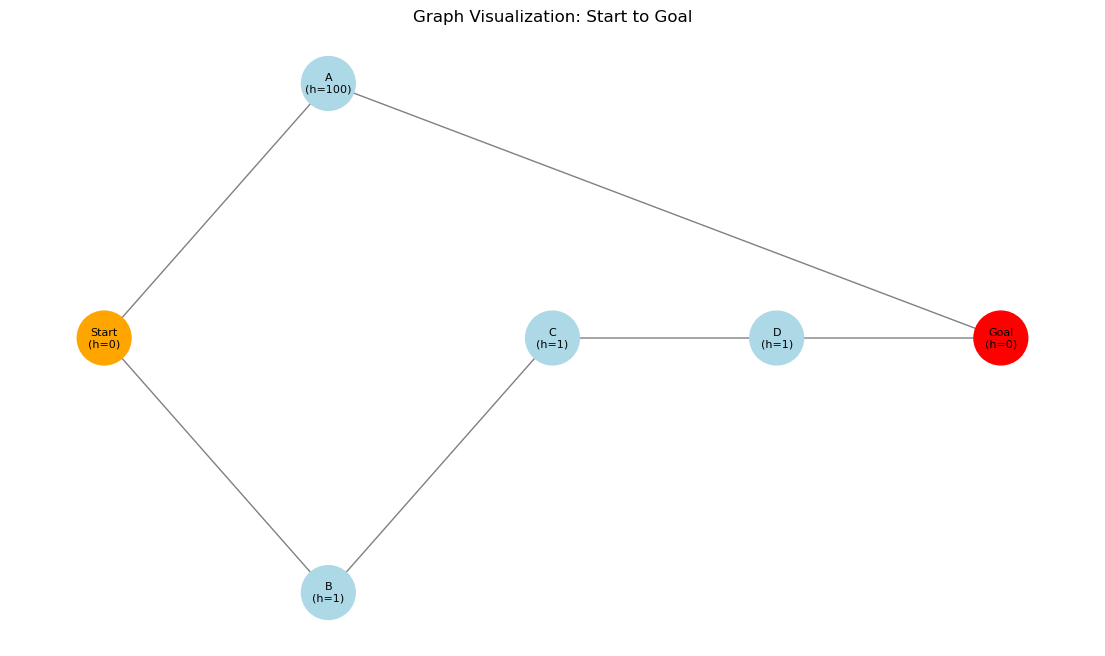

In [15]:
fig = generate_graph_plot(risky_data)
plt.show()

In [16]:
path_1 = solve_beam_search(risky_data, 1)

Step 1 | width: 1 | current beam: [(0, 'Start')]
[(2, 'B')]
Step 2 | width: 1 | current beam: [(2, 'B')]
[(3, 'C')]
Step 3 | width: 1 | current beam: [(3, 'C')]
[(4, 'D')]
Step 4 | width: 1 | current beam: [(4, 'D')]
[(103, 'Goal')]
Step 5 | width: 1 | current beam: [(103, 'Goal')]
Goal found! Hooray!


In [17]:
path_2 = solve_beam_search(risky_data, 2)

Step 1 | width: 2 | current beam: [(0, 'Start')]
[(2, 'B'), (101, 'A')]
Step 2 | width: 2 | current beam: [(2, 'B'), (101, 'A')]
[(2, 'Goal'), (3, 'C')]
Step 3 | width: 2 | current beam: [(2, 'Goal'), (3, 'C')]
Goal found! Hooray!


In [18]:
path_1

(['Start', 'B', 'C', 'D', 'Goal'],
 {'Start': 0, 'A': 1, 'B': 1, 'C': 2, 'D': 3, 'Goal': 103})

In [ ]:
path_2